In [7]:
%cd ../ground_truth_generator

/home/jupyter/recVisFinalProject/ground_truth_generator


In [8]:
scenario = "deadly_corridor.cfg"
vizualize = True

creating train set ...
episode 1 running ...
episode 2 running ...
episode 3 running ...
episode 4 running ...
episode 5 running ...
episode 6 running ...
episode 7 running ...
episode 8 running ...
episode 9 running ...
episode 10 running ...

creating val set ...
episode 1 running ...
episode 2 running ...

creating batches ...


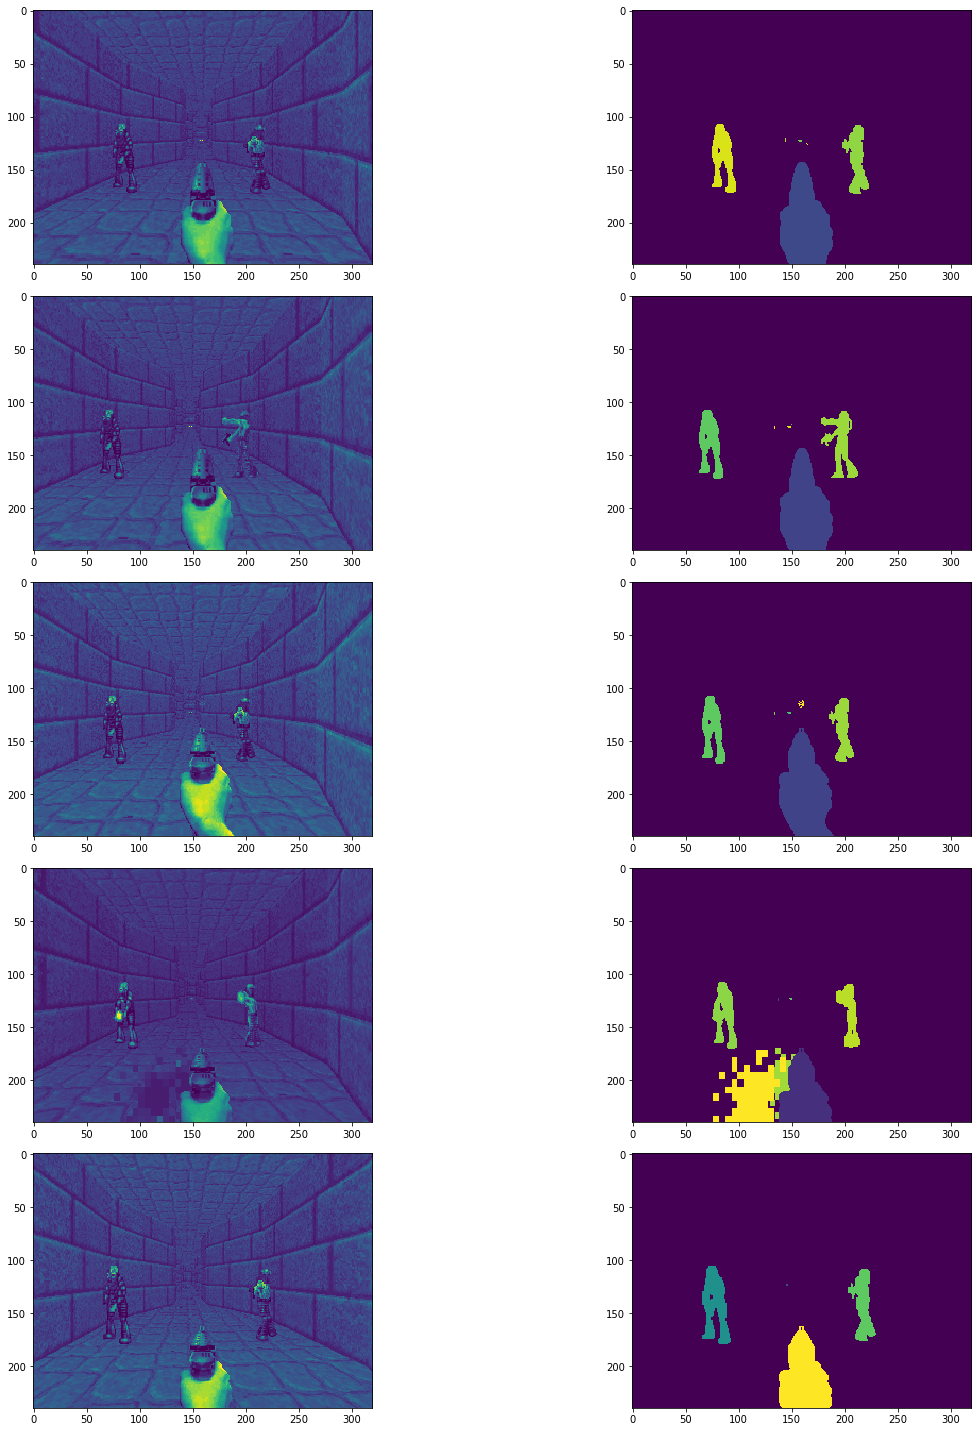

In [11]:
from vizdoom import *
import random
import time
import numpy as np 
import skimage.color, skimage.transform
import matplotlib.pyplot as plt
import random
import torch
import pickle


batch_size = 1


# GROUND TRUTHS SEGMENTATION
def encode(labels, labels_figures):
    for i in range(len(labels_figures)):
        labels[labels == labels_figures[i]] = i
    return labels


# INIT GAME  
game = DoomGame()
game.load_config("scenarios/" + scenario)

game.set_window_visible(False)
game.set_render_hud(False)
game.set_mode(Mode.PLAYER)
# Enables labeling of the in game objects.
game.set_labels_buffer_enabled(True)
game.set_screen_resolution(ScreenResolution.RES_320X240) # RES_320X240, RES_640X480, RES_1920X1080
game.set_screen_format(ScreenFormat.GRAY8) # grayscale image  CRCGCB, RGB24, GRAY8, BGR24

game.init()

def define_actions(game):
    actions = list()
    buttons = len(game.get_available_buttons())
    for i in range(buttons):
        button = [1 if j == i else 0 for j in range(buttons)]
        actions.append(button)
    return actions

actions = define_actions(game)

episodes_train = 10
episodes_val = 2

if __name__ == '__main__':

    # create dict of tensors. validation and train / use pickle file (for the moment)
    data = {'train': {'X': list(), 'y': list()}, 'val': {'X': list(), 'y': list()}}
    train_X = list()
    train_y = list()

    # create train set 
    print('creating train set ...')
    labels_figures = [0]
    for i in range(episodes_train):
        game.new_episode()
        print(f'episode {i + 1} running ...')
        while not game.is_episode_finished():
            state = game.get_state()
            img = state.screen_buffer
            labels = state.labels_buffer
            for label in state.labels:
                if label.value not in labels_figures:
                    labels_figures.append(label.value)
            # retrieve data :
            train_X.append(torch.from_numpy(img.reshape((1, img.shape[0], img.shape[1])).astype(np.float))) 
            train_y.append(torch.from_numpy(encode(labels, labels_figures).reshape((1, img.shape[0], img.shape[1]))))
            game.make_action(random.choice(actions))


        # create val set 
    print('\ncreating val set ...')
    for i in range(episodes_val):
        game.new_episode()
        print(f'episode {i + 1} running ...')
        while not game.is_episode_finished():
            state = game.get_state()
            img = state.screen_buffer
            labels = state.labels_buffer
            # retrieve data :
            data['val']['X'].append(torch.from_numpy(img.reshape((1, 1, img.shape[0], img.shape[1])).astype(np.float)))
            data['val']['y'].append(torch.from_numpy(encode(labels, labels_figures).reshape((1, 1, img.shape[0], img.shape[1]))))
            game.make_action(random.choice(actions))
       
    game.close()

    # create batches
    print('\ncreating batches ...')
    indices = list(range(len(train_X)))
    random.shuffle(indices)
    for i in range(len(train_X)//batch_size):
        batch_X = list()
        batch_y = list()
        for j in range(batch_size):
            batch_X.append(train_X[indices[i*batch_size + j]])
            batch_y.append(train_y[indices[i*batch_size + j]])
        batch_X = torch.stack(batch_X)
        batch_y = torch.stack(batch_y)
        data['train']['X'].append(batch_X)
        data['train']['y'].append(batch_y)


    # save into pickle file
    pickle.dump(data, open('data', 'wb'))
    pickle.dump(labels_figures, open('labels_figures', 'wb'))

    # SHOW SOME EXAMPLES
    if vizualize :
        fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))
        for k in range(5):
            tmp = random.choice(range(len(data['val']['X'])))
            axes[k][0].imshow(data['val']['X'][tmp][0, 0, :])
            axes[k][1].imshow(data['val']['y'][tmp][0, 0, :])
        fig.tight_layout()
        plt.show()


In [1]:
import torch
from torch import nn
import torch.nn.functional as F



class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = nn.Sequential(
                    nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(out_channels), 
                    nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(out_channels),
                    )
        return block


    def expansive_block(self, in_channels, mid_channels, out_channels, kernel_size=3):
        block = nn.Sequential(
                    nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channels),
                    nn.ReLU(),
                    nn.BatchNorm2d(mid_channels),
                    nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channels, out_channels=mid_channels),
                    nn.ReLU(mid_channels),
                    nn.ConvTranspose2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
        return block

    def final_block(self, in_channels, mid_channels, out_channels, kernel_size=3):
        block = nn.Sequential(
                    nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channels, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(mid_channels),
                    nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channels, out_channels=mid_channels, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(mid_channels),
                    nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channels, out_channels=out_channels, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(out_channels)
                    # the number of feature maps equal to the number of segments desired.
                    )
        return block

    def __init__(self, in_channel, out_channel):
        # out_channel represents number of segments desired
        super(UNet, self).__init__()
        # Encode (contraction)
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = nn.MaxPool2d(kernel_size=2)
        # The number of feature maps after each block doubles so that architecture can learn the complex structures 

        # Bottleneck
        self.bottleneck = nn.Sequential(
                            nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            nn.ReLU(),
                            nn.BatchNorm2d(512),
                            nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            nn.ReLU(),
                            nn.BatchNorm2d(512),
                            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )


        # Decode (expansion)
        self.conv_decode3 = self.expansive_block(512, 256, 128) 
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer =  self.final_block(128, 64, out_channel)


	def crop_and_concat(self, upsampled, bypass, crop=False):
        """
        The function crop_and_concat appends the output 
        of contraction layer with the new expansion layer input.
        """
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            if (bypass.size()[2] - upsampled.size()[2]) % 2 == 0:
                upsampled = F.pad(upsampled, (c, c, c, c))
            else:
                upsampled = F.pad(upsampled, (c+1, c, c+1, c))
        return torch.cat((upsampled, bypass), 1)


    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)

        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)

        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer


In [13]:
%cd ../object_recognition_algo

/home/jupyter/recVisFinalProject/object_recognition_algo


loading data
input size : 320, 240
output size : 320, 240
number of objects to identify : 35
model created
Epoch 0/3
----------
learning
train loss = 0.19 
validation
validation loss = 0.095
Epoch 1/3
----------
learning
train loss = 0.0789 
validation
validation loss = 0.0878
Epoch 2/3
----------
learning
validation loss = 0.0923
Epoch 3/3
----------
learning
train loss = 0.0609 
validation
validation loss = 0.0934
model saved to segmentation.pth
showing examples :


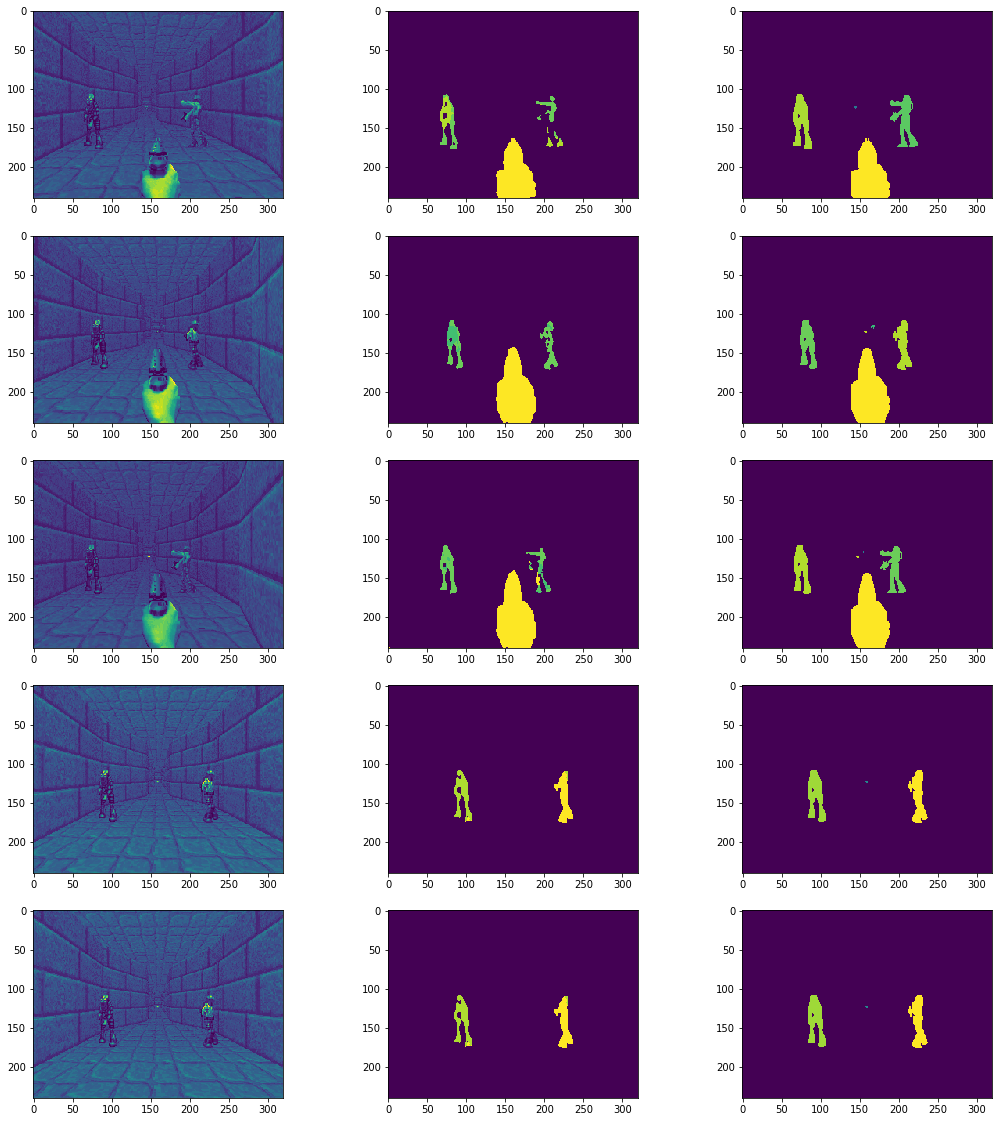

In [14]:
from tqdm import tqdm_notebook as tqdm
import torch
import torch.optim as optim
from torch import nn
import numpy as np
import pickle
import matplotlib.pyplot as plt

# gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#########################
# training functions
def training_step(model, batch_X, batch_y, criterion, optimizer, width_out, height_out, n_classes):
	inputs = batch_X.to(device)
	truths = batch_y.to(device)
	optimizer.zero_grad()
	with torch.set_grad_enabled(True):
		outputs = model(inputs.float())
		outputs = outputs.permute(0, 2, 3, 1)
		# outputs.shape = (batch_size, n_classes, img_cols, img_rows)
		m = outputs.shape[0]      
		outputs = outputs.view(m*width_out*height_out, n_classes)
		# outputs.shape =(batch_size, img_cols, img_rows, n_classes)
		truths = truths.view(m*width_out*height_out)
		loss = criterion(outputs, truths.long())
		loss.backward()
		optimizer.step()
	return loss

def validation_step(model, criterion, val_X, val_y, width_out, height_out, n_classes):
	inputs = val_X.to(device)
	truths = val_y.to(device)
	with torch.no_grad():
		outputs = model(inputs.float())
		outputs = outputs.permute(0, 2, 3, 1)
		# outputs.shape = (batch_size, n_classes, img_cols, img_rows)
		m = outputs.shape[0]
		outputs = outputs.view(m*width_out*height_out, n_classes)
		# outputs.shape = (batch_size, img_cols, img_rows, n_classes)
		truths = truths.view(m*width_out*height_out)
		loss = criterion(outputs, truths.long())
	return loss

def train(model, criterion, optimizer, num_epochs, data, algo, width_out, height_out, n_classes):
	len_train = len(data['train']['X'])
	len_val = len(data['val']['X'])
	for epoch in range(num_epochs):
		print('Epoch {}/{}'.format(epoch, num_epochs - 1))
		print('-' * 10)
		train_loss = 0
		val_loss = 0
		for phase in ['train', 'val']:
			if phase == 'train':
				print("learning")
				model.train()
				for batch_X, batch_y in zip(data['train']['X'], data['train']['y']):
					train_loss += training_step(model, batch_X, batch_y, criterion, optimizer, width_out, height_out, n_classes)
				print(f'train loss = {round(float(train_loss / len_train), 4)} ')
			else:
				print("validation")
				model.eval()
				for val_X, val_y in zip(data['val']['X'], data['val']['y']):
					val_loss += validation_step(model, criterion, val_X, val_y, width_out, height_out, n_classes)
				print(f'validation loss = {round(float(val_loss / len_val), 4)}')
	torch.save(model.state_dict(), algo + '.pth')
	print('model saved to ' + algo + '.pth')
##########################


##########################
def plot_examples(model, datax, datay, num_examples, labels_figures):
	model.eval()
	fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(18, 4*num_examples))
	m = len(datax)
	for row_num in range(num_examples):
		image_indx = np.random.randint(m)
		image_arr = model(datax[image_indx].to(device).float())
		image_arr = image_arr.squeeze(0).detach().cpu().numpy()
		ax[row_num][0].imshow(datax[image_indx][0, 0, :, :])  # show input 1st channel
		ax[row_num][1].imshow(decode(image_arr.argmax(0), labels_figures))  # show argmax of result of unet
		ax[row_num][2].imshow(decode(datay[image_indx][0, 0, :, :], labels_figures))  # show ground truth
	plt.show()
    
def decode(output, labels_figures):
    for i in range(len(labels_figures)):
        output[output == i] = labels_figures[i]
    return output
#########################


#########################
def main():
	# data
	train_model = True
	print("loading data")
	data = pickle.load(open('../ground_truth_generator/data', 'rb'))
	labels_figures = pickle.load(open('../ground_truth_generator/labels_figures', 'rb'))
	width_in = data['val']['X'][0].shape[2]
	height_in = data['val']['X'][0].shape[3]
	print(f'input size : {height_in}, {width_in}')
	width_out = data['val']['y'][0].shape[2]
	height_out = data['val']['y'][0].shape[3]
	print(f'output size : {height_out}, {width_out}')
	n_classes = len(labels_figures)
	print(f'number of objects to identify : {n_classes}')
	# parameters
	num_epochs = 4
	# model
	in_channel =  1 # 1 if gray scale, 3 if RGB
	out_channel = n_classes # number of segments  (depends on the environment) should be len(np.unique(labels))
	model = UNet(in_channel, out_channel).to(device)
	print('model created')
	# criterion
	criterion = nn.CrossEntropyLoss()
	# optimizer
	optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.99)
	# algo
	algo = 'segmentation'
	# train
	if train_model:    
		train(model, criterion, optimizer, num_epochs, data, algo, width_out, height_out, n_classes)
	else:
		print('loading pre-trained model...')
		state_dict = torch.load(algo + '.pth')        
		model.load_state_dict(state_dict)
	print("showing examples :")
	plot_examples(model, data['val']['X'], data['val']['y'], 5, labels_figures)


if __name__ == '__main__':
	main()